# **Ouroboros EEG-fMRI NF: Predicting EEG activity, fMRI activity and NF scores**

#### Version: 28th October 2022

==============================================================================================

Project developed by Maël Donoso, Ph.D. in Cognitive and Computational Neuroscience. Affiliations: Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/), Institut Lémanique du Cerveau (https://institut-cerveau.ch/), Policlinique Ostéopathique de Lausanne (https://policlinique-osteopathique-lausanne.ch/). 

==============================================================================================

This project is presented through six Notebooks:

*01: Data Analysis*

*02: Classification* (all classification models except neural networks)

*03: Neural Networks*

***04: Regression on fMRI Data***

*05: Regression on EEG Data*

*06: Results*

==============================================================================================

### Notebook 04

# **Regression on fMRI data**

## **1. Introduction to Regression on fMRI data**

### 1.1 Objective

The objective of this project is to **explore several ways to apply machine learning models to a given EEG-fMRI NF dataset, and to evaluate which ones result in interesting predictions**. In this Notebook, we will evaluate whether fMRI data can be used to predict EEG data, fMRI NF scores and EEG NF scores. In a sense, predicting fMRI NF scores will be a control experiment, since fMRI data was directly used by the authors of the dataset to compute the fMRI NF scores in the first place. On the other hand, the EEG NF scores were computed independently. 

### 1.2 Models

We will use several regression models and fine-tune their hyperparameters when relevant: **linear regression**, **regression with Huber loss**, **Ridge regression**, **Lasso regression**. For the fine-tuning, we will use a grid search approach, and store the test score as well as the value of the best hyperparameter found. The baseline will be a model that predicts the mean value from the train set. 

### 1.3 Data import

Here we import the **EEG and fMRI data**. For the latter, we store the data in dictionaries. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define the raw data path. 
data_path = '../ouroboros_eeg-fmri_nf_raw_data/'

# Define the preprocessed data path. 
preprocessed_data_path = '../ouroboros_eeg-fmri_nf_preprocessed_data/'

# Define the results path. If empty, the results will be saved in the current directory. 
results_path = ''

In [3]:
# Define the list of subjects. 
subjects = []

for subject_index in range(10):
    if subject_index < 9:
        subjects.append('sub-xp10' + str(subject_index + 1))
    else:
        subjects.append('sub-xp1' + str(subject_index + 1))

print(subjects)

['sub-xp101', 'sub-xp102', 'sub-xp103', 'sub-xp104', 'sub-xp105', 'sub-xp106', 'sub-xp107', 'sub-xp108', 'sub-xp109', 'sub-xp110']


In [4]:
# Load the EEG predictors. 
with open(preprocessed_data_path + 'predictors_EEG_200_samples.p', 'rb') as file:
    predictors_EEG_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_1600_samples.p', 'rb') as file:
    predictors_EEG_1600_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_200_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_200_samples = pickle.load(file)
with open(preprocessed_data_path + 'predictors_EEG_single_subject_all_channels_1600_samples.p', 'rb') as file:
    predictors_EEG_single_subject_all_channels_1600_samples = pickle.load(file)

In [5]:
# Load the fMRI data, and store the data in dictionaries. 
predictors_fMRI = dict()
predictors_fMRI_r2 = dict()
predictors_fMRI_r3 = dict()

# Iterate through all subjects. 
counter = 1
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject ' + str(counter) + ' / ' + str(len(subjects)))
    
    # Load fMRI data with the original voxel size. 
    with np.load(preprocessed_data_path + 'predictors_fMRI.npz', allow_pickle = False) as npz_file:
        predictors_fMRI[subject_index] = npz_file['sub_' + str(counter)]
    
    # Load fMRI data with the voxel size rescaling by a factor 2. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r2.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r2[subject_index] = npz_file['sub_' + str(counter)]
        
    # Load fMRI data with the voxel size rescaling by a factor 3. 
    with np.load(preprocessed_data_path + 'predictors_fMRI_r3.npz', allow_pickle = False) as npz_file:
        predictors_fMRI_r3[subject_index] = npz_file['sub_' + str(counter)]
        
    # Increment. 
    counter += 1

Starting subject 1 / 10
Starting subject 2 / 10
Starting subject 3 / 10
Starting subject 4 / 10
Starting subject 5 / 10
Starting subject 6 / 10
Starting subject 7 / 10
Starting subject 8 / 10
Starting subject 9 / 10
Starting subject 10 / 10


In [6]:
# Determine the proportion of the test set for the classification models. 
test_set_proportion = 0.2

## **2. Preliminary steps**

### **2.1 Define functions**

In the following cells, we define a series of **functions to run regression models and display the results**. 

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [8]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [9]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [10]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [11]:
# Define a function to run a regression model. 
def regression_model(Linear_Model, X_tr, X_te, y_tr, y_te, display_results = True, return_rank = False):
    
    # Fit the regression model and compute predictions. 
    lm = Linear_Model # LinearRegression(), HuberRegressor(), Ridge(), Lasso()
    lm.fit(X_tr, y_tr)
    y_pred_lm = lm.predict(X_te)
    
    # Compute the MSE, MAE and RSS measures. 
    mse_lm = MSE(y_te, y_pred_lm)
    mae_lm = MAE(y_te, y_pred_lm)
    rss_lm = RSS(y_te, y_pred_lm)
    if display_results == True:
        print('MSE:', mse_lm)
        print('MAE:', mae_lm)
        print('RSS:', rss_lm)

    # Compute the R^2 measure. 
    r2_lm = 1 - (rss_lm / rss_baseline)
    if display_results == True:
        print('R^2: ' + str(r2_lm))
        
    # Retrieve the rank. 
    if return_rank == True:
        rank = lm.rank_
    else:
        rank = None
    
    return y_pred_lm, mse_lm, mae_lm, rss_lm, r2_lm, lm.coef_, rank

In [12]:
# Define a function to fine-tune a Ridge or Lasso regression. 
def fine_tune_ridge_or_lasso(Linear_Model, X_tr, X_te, y_tr, y_te, alpha_values):
    
    # Create a list to store the results. 
    gs_results = []
    counter = 0

    # Fine-tune the regression model with a grid search. 
    for alpha in alpha_values:
        
        # Display step. 
        print('Starting step ' + str(counter) + ' / ' + str(len(alpha_values)))
        
        # Iterate. 
        for run_idx in range(5):
            
            # Create Ridge or Lasso regression. 
            lm = Linear_Model(alpha = alpha, max_iter = 20)

            # Split into train / valid sets. 
            X_tr2, X_va, y_tr2, y_va = train_test_split(
                X_tr, y_tr, test_size = 0.2, random_state = run_idx)

            # Fit the model. 
            lm.fit(X_tr2, y_tr2)

            # Save alpha value and model performance on train and validaton sets. 
            gs_results.append({
                'alpha': alpha,
                'train_mse': MSE(y_tr2, lm.predict(X_tr2)),
                'valid_mse': MSE(y_va, lm.predict(X_va)),
            })
            
        # Increment. 
        counter += 1
            
    return gs_results

In [13]:
# Define a function to display the results of the Ridge or Lasso regression fine-tuning. 
def display_ridge_or_lasso_fine_tuning(gs_results, alpha_values):
    
    # Convert results to DataFrame. 
    gs_results = pd.DataFrame(gs_results)

    # Group results by alpha value. 
    grouped = gs_results.groupby('alpha')

    # Compute train / valid mean scores with std. 
    mean_tr = grouped.train_mse.mean()
    mean_va = grouped.valid_mse.mean()
    std_tr = grouped.train_mse.std()
    std_va = grouped.valid_mse.std()

    # Plot the validation curves. 
    plt.plot(np.log10(alpha_values), mean_tr, color = 'blue', label = 'train curve')
    plt.plot(np.log10(alpha_values), mean_va, color = 'green', label = 'valid curve')

    # Mark best alpha value. 
    best_alpha = mean_va.idxmin()
    plt.scatter(np.log10(best_alpha), mean_va.min(), marker = 'x', c = 'green', zorder = 10)

    # Quantify variance with ±std curves. 
    plt.fill_between(np.log10(alpha_values), mean_tr - std_tr, mean_tr + std_tr, color = 'blue', alpha = 0.2)
    plt.fill_between(np.log10(alpha_values), mean_va - std_va, mean_va + std_va, color = 'green', alpha = 0.2)

    # Add title and labels. 
    plt.title('Best alpha: {:.2e} - MSE: {:.4f}'.format(best_alpha, mean_va.min()))
    plt.xlabel('$log_{10}(alpha)$')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()
    
    return best_alpha

In [14]:
# Define a function for mapping the coefficients from the regression model to the 3D brain image. 
def create_coefficients_image(non_nan_indexes, coef):
    
    # Create a NumPy array with the appropriate shape. 
    coefficients_image = np.zeros(non_nan_indexes.shape)
    coefficients_image[:] = np.nan

    # Fill in this array with the coefficients, at the indexes corresponding to non-NaN values. 
    coefficients_image[non_nan_indexes] = coef
    
    return coefficients_image

In [15]:
# Define a function to return the middle sections of an image data array. 
def middle_sections(image_data):
    return tuple((np.array(image_data[:, :, :].shape) / 2).astype(int))

In [16]:
# Define a function to display sections of an image through the sagittal, coronal and axial views, using the middle sections coordinates. 
def display_fMRI_image(image_data, middle_coord, scan = 0, colormap = 'summer'):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 5))
    axes[0].imshow(image_data[middle_coord[0], :, :, scan].T, origin = 'lower', cmap = colormap)
    axes[0].set_title('Sagittal view')
    axes[1].imshow(image_data[:, middle_coord[1], :, scan].T, origin = 'lower', cmap = colormap)
    axes[1].set_title('Coronal view')
    axes[2].imshow(image_data[:, :, middle_coord[2], scan], origin = 'lower', cmap = colormap)
    axes[2].set_title('Axial view');

In [17]:
# Define a function to display the position of a voxel or cluster, with one image as background. 
def display_voxel_or_cluster_position(voxel_index, background_image, image_data_shape):
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))

    # Sagittal view. 
    axes[0].imshow(background_image[voxel_index[0], :, :].T, origin = 'lower')
    axes[0].axhline(voxel_index[2], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[0].axvline(voxel_index[1], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[0].scatter(voxel_index[1], voxel_index[2], marker = 'o', c = 'white')
    axes[0].set_title('Sagittal view')

    # Coronal view. 
    axes[1].imshow(background_image[:, voxel_index[1], :].T, origin = 'lower')
    axes[1].axhline(voxel_index[2], 0, image_data_shape[0], color = 'yellow') # Horizontal line through sagittal view. 
    axes[1].axvline(voxel_index[0], 0, image_data_shape[2], color = 'yellow') # Vertical line through axial view. 
    axes[1].scatter(voxel_index[0], voxel_index[2], marker = 'o', c = 'white')
    axes[1].set_title('Coronal view')

    # Axial view. 
    axes[2].imshow(background_image[:, :, voxel_index[2]], origin = 'lower')
    axes[2].axhline(voxel_index[0], 0, image_data_shape[1], color = 'yellow') # Horizontal line through coronal view. 
    axes[2].axvline(voxel_index[1], 0, image_data_shape[0], color = 'yellow') # Vertical line through sagittal view. 
    axes[2].scatter(voxel_index[1], voxel_index[0], marker = 'o', c = 'white')
    axes[2].set_title('Axial view')
    plt.show();

### **2.2 Prepare the fMRI data**

In the following cells, we **prepare the preprocessed fMRI data for the regression models**. In this step, we flatten the 3D brain images and remove all NaN values. Nevertheless, we keep the position of non-NaN voxels from the original 3D image, in order to be able to reconstruct the 3D structure if necessary. 

In [18]:
# Define a function to flatten the 3D brain images and remove all NaN values. 
def flatten_preprocessed_fMRI_data(predictors_fMRI):
    
    # Create new dictionaries to store the formatted fMRI data and the non-NaN indexes. 
    predictors_fMRI_flatten = dict()
    non_nan_indexes_fMRI = dict()

    # Iterate through all subjects. 
    for subject_index in subjects:

        # Display current step. 
        print('Starting subject ' + subject_index)

        # Load the data, and retrieve the number and position of non-NaN voxels per scan. 
        image_data = predictors_fMRI[subject_index]
        non_nan_indexes = ~np.isnan(image_data[:, :, :, 0])
        nb_non_nan = np.sum(non_nan_indexes)

        # Retrieve the number of scans, then create a NumPy array with one row per scan and one column per non-NaN voxel. 
        nb_scans = image_data.shape[3]
        formatted_data = np.empty((nb_scans, nb_non_nan))

        # Fill in the array. 
        for scan in range(nb_scans):
            flatten_image = image_data[:, :, :, scan].flatten()
            flatten_image = flatten_image[~np.isnan(flatten_image)]
            formatted_data[scan, :] = flatten_image

        # Fill in the dictionary. 
        predictors_fMRI_flatten[subject_index] = formatted_data
        non_nan_indexes_fMRI[subject_index] = non_nan_indexes
        
    return predictors_fMRI_flatten, non_nan_indexes_fMRI

In [19]:
# Flatten the preprocessed fMRI data with the original voxel size. 
predictors_fMRI_flatten, non_nan_indexes_fMRI = flatten_preprocessed_fMRI_data(predictors_fMRI)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [20]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 2. 
predictors_fMRI_flatten_r2, non_nan_indexes_fMRI_r2 = flatten_preprocessed_fMRI_data(predictors_fMRI_r2)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


In [21]:
# Flatten the preprocessed fMRI data with the voxel size rescaling by a factor 3. 
predictors_fMRI_flatten_r3, non_nan_indexes_fMRI_r3 = flatten_preprocessed_fMRI_data(predictors_fMRI_r3)

Starting subject sub-xp101
Starting subject sub-xp102
Starting subject sub-xp103
Starting subject sub-xp104
Starting subject sub-xp105
Starting subject sub-xp106
Starting subject sub-xp107
Starting subject sub-xp108
Starting subject sub-xp109
Starting subject sub-xp110


## **3. Regression on a single subject, EEG data prediction**

### **3.1 Target: the alpha band**

In the following cells, we **fit and compute predictions from a linear regression, a regression with Huber loss, a Ridge regression and a Lasso regression** for a single subject, using the alpha band as the target. For the Ridge regression and the Lasso regression, we fine-tune the alpha parameter, which corresponds to the regularization strength. 

In [22]:
# Define an example subject. 
subject_index = subjects[0]

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [23]:
# Display the shape of the EEG predictors for this subject. 
predictors_EEG_200_samples[subject_index].shape

(200, 5)

In [24]:
# Define the alpha band as our EEG frequency band of interest. 
target_band_index = 2

In [25]:
# Define the features and target variables. 
if rescaling_factor == 1:
    X = predictors_fMRI_flatten[subject_index]
elif rescaling_factor == 2:
    X = predictors_fMRI_flatten_r2[subject_index]
elif rescaling_factor == 3:
    X = predictors_fMRI_flatten_r3[subject_index]
y = predictors_EEG_200_samples[subject_index][:, target_band_index]
print('X:', X.shape)
print('y:', y.shape)
print('X:', type(X))
print('y:', type(y))

X: (200, 100674)
y: (200,)
X: <class 'numpy.ndarray'>
y: <class 'numpy.ndarray'>


In [26]:
# Divide the data into a train set and a test set. 
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
print('Train set:')
print('X_tr:', X_tr.shape)
print('y_tr:', y_tr.shape)
print('Test set:')
print('X_te:', X_te.shape)
print('y_te:', y_te.shape)

Train set:
X_tr: (160, 100674)
y_tr: (160,)
Test set:
X_te: (40, 100674)
y_te: (40,)


In [27]:
# Baseline model: mean value of the alpha band in the train set. 
mae_baseline = MAE(y_te, np.mean(y_tr))
mse_baseline = MSE(y_te, np.mean(y_tr))
rss_baseline = RSS(y_te, np.mean(y_tr))
print('MSE baseline:', mse_baseline)
print('MAE baseline:', mae_baseline)
print('RSS baseline:', rss_baseline)

MSE baseline: 0.01670369361495066
MAE baseline: 0.09735752409485796
RSS baseline: 0.6681477445980263


#### 3.1.1 Linear regression

In [28]:
import seaborn as sns

/Users/maeldonoso/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [29]:
# Run a linear regression. 
y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
    LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)

MSE: 0.012040249266886842
MAE: 0.08081799266992283
RSS: 0.4816099706754737
R^2: 0.27918641562545154


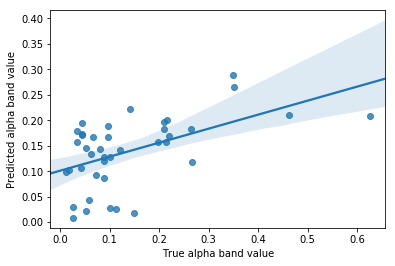

In [30]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_lr)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [31]:
# Compare the rank of the matrix X_tr with its shape. 
print('X_tr rank: ' + str(rank_lr))
print('X_tr shape: ' + str(X_tr.shape))

X_tr rank: 160
X_tr shape: (160, 100674)


In [32]:
# Display the shape of the coefficients from the regression model. 
coef_lr.shape

(100674,)

In [33]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)

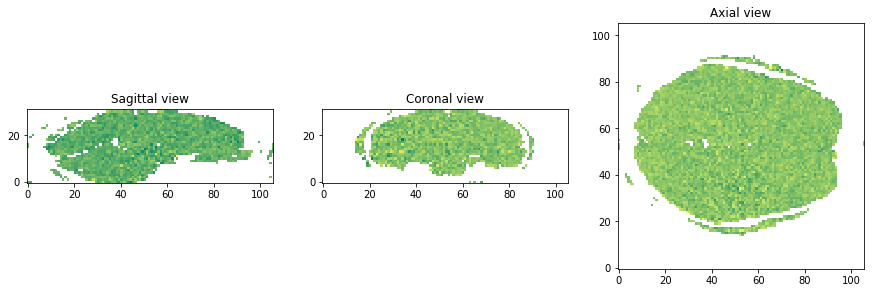

In [34]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_lr)
display_fMRI_image(coefficients_image_lr[:, :, :, np.newaxis], middle_coord)

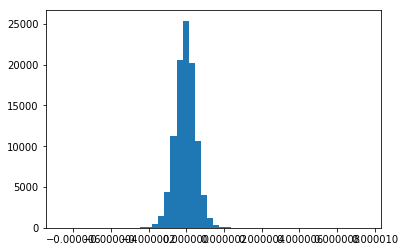

In [35]:
# Display the distribution of the coefficient values. 
plt.hist(coef_lr, bins = 50);

**Result:** The linear regression performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. 

#### 3.1.2 Regression with Huber loss

In [36]:
# Run a regression with Huber loss. 
y_pred_huber, mse_huber, mae_huber, rss_huber, r2_huber, coef_huber, _ = regression_model(
    HuberRegressor(epsilon = 1.35), X_tr, X_te, y_tr, y_te)

MSE: 0.012409098463678572
MAE: 0.0830733319723522
RSS: 0.49636393854714284
R^2: 0.2571045213274389


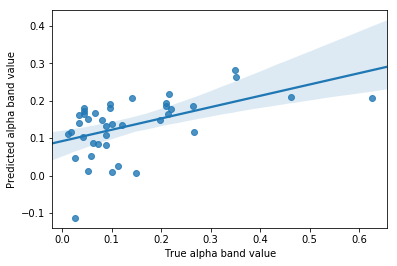

In [37]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_huber)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [38]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_huber = create_coefficients_image(non_nan_indexes, coef_huber)

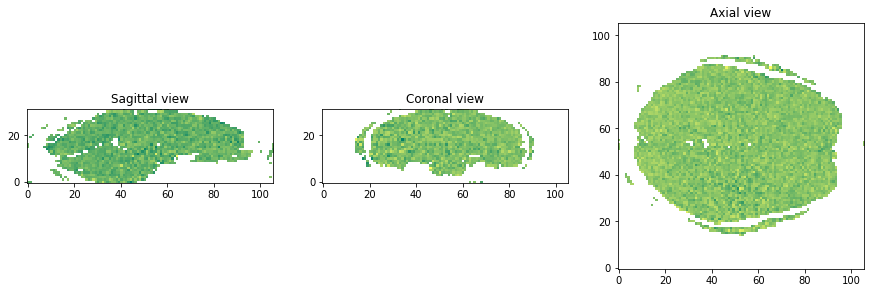

In [39]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_huber)
display_fMRI_image(coefficients_image_huber[:, :, :, np.newaxis], middle_coord)

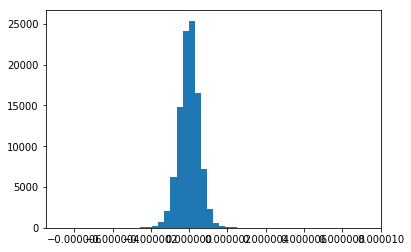

In [40]:
# Display the distribution of the coefficient values. 
plt.hist(coef_huber, bins = 50);

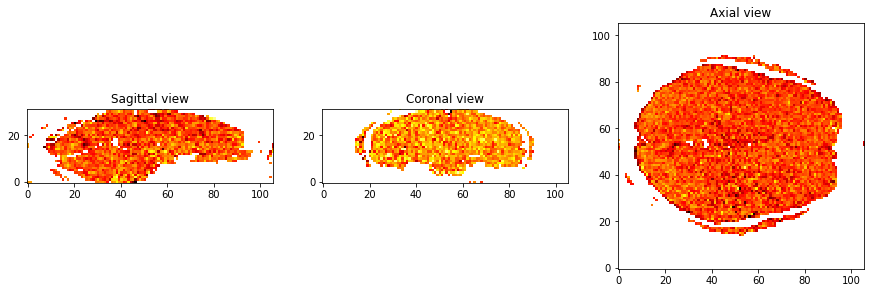

In [41]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_huber[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

**Result:** The regression with Huber loss performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. 

#### 3.1.3 Ridge regression

In [42]:
# Define the range of alpha values to explore for the Ridge regression. 
alpha_values = np.logspace(2, 10, num = 10)

In [43]:
# Fine-tune a Ridge regression. 
gs_results = fine_tune_ridge_or_lasso(Ridge, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


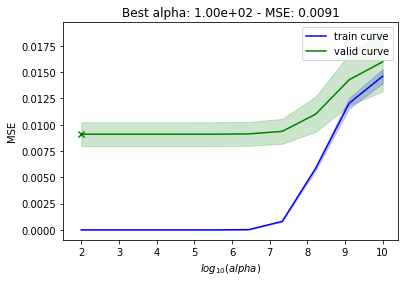

In [44]:
# Display fine-tuning results. 
best_alpha_ridge = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [45]:
# Run a Ridge regression. 
y_pred_ridge, mse_ridge, mae_ridge, rss_ridge, r2_ridge, coef_ridge, _ = regression_model(
    Ridge(alpha = best_alpha_ridge), X_tr, X_te, y_tr, y_te)

MSE: 0.012041254126324867
MAE: 0.08082223256251277
RSS: 0.4816501650529947
R^2: 0.27912625770701815


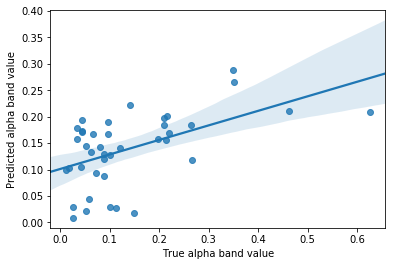

In [46]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_ridge)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [47]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_ridge = create_coefficients_image(non_nan_indexes, coef_ridge)

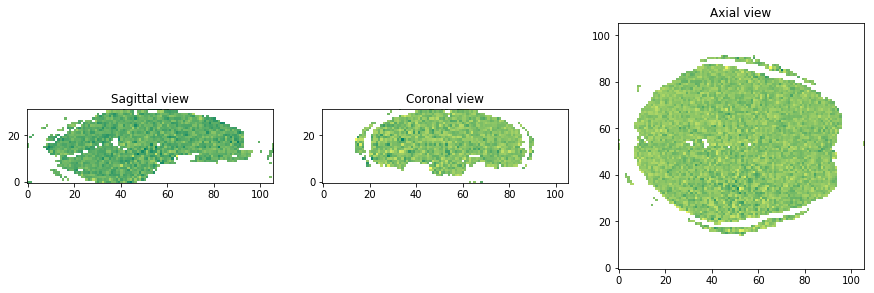

In [48]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_ridge)
display_fMRI_image(coefficients_image_ridge[:, :, :, np.newaxis], middle_coord)

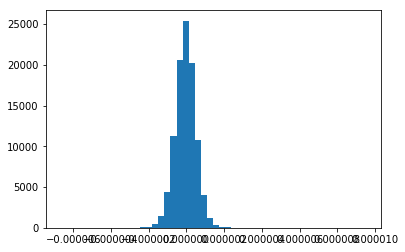

In [49]:
# Display the distribution of the coefficient values. 
plt.hist(coef_ridge, bins = 50);

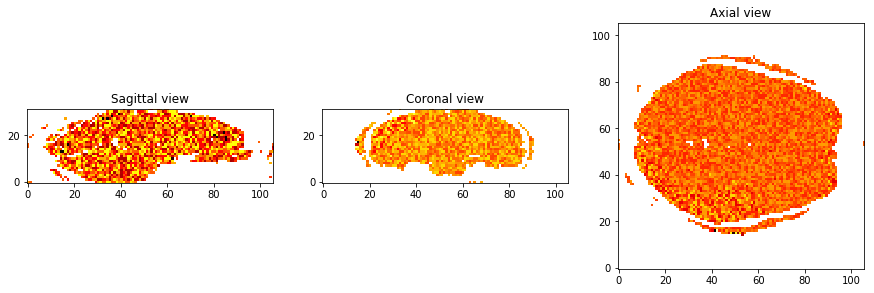

In [50]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_ridge[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

**Result:** The Ridge regression performs better than the baseline. The voxels associated with the highest coefficients do not seem to be located in a particular brain region. 

#### 3.1.4 Lasso regression

In [51]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Disable ConvergenceWarning error message. 
simplefilter("ignore", category = ConvergenceWarning)

In [52]:
# Define the range of alpha values to explore for the Lasso regression. 
alpha_values = np.logspace(-5, 1, num = 10)

In [53]:
# Fine-tune a Lasso regression. 
gs_results = fine_tune_ridge_or_lasso(Lasso, X_tr, X_te, y_tr, y_te, alpha_values)

Starting step 0 / 10
Starting step 1 / 10
Starting step 2 / 10
Starting step 3 / 10
Starting step 4 / 10
Starting step 5 / 10
Starting step 6 / 10
Starting step 7 / 10
Starting step 8 / 10
Starting step 9 / 10


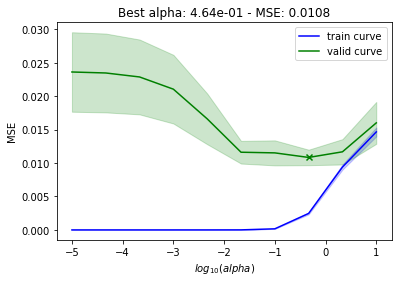

In [54]:
# Display fine-tuning results. 
best_alpha_lasso = display_ridge_or_lasso_fine_tuning(gs_results, alpha_values)

In [55]:
# Run a Lasso regression. 
y_pred_lasso, mse_lasso, mae_lasso, rss_lasso, r2_lasso, coef_lasso, _ = regression_model(
    Lasso(alpha = best_alpha_lasso), X_tr, X_te, y_tr, y_te)

MSE: 0.015204653498202148
MAE: 0.09251935257662235
RSS: 0.6081861399280859
R^2: 0.08974303236781067


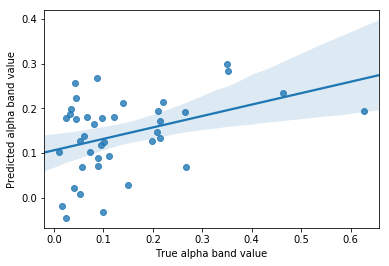

In [56]:
# Compare the true values with the predicted values. 
sns.regplot(y_te, y_pred_lasso)
plt.xlabel('True alpha band value')
plt.ylabel('Predicted alpha band value');

In [57]:
# Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
if rescaling_factor == 1:
    non_nan_indexes = non_nan_indexes_fMRI[subject_index]
elif rescaling_factor == 2:
    non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
elif rescaling_factor == 3:
    non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
coefficients_image_lasso = create_coefficients_image(non_nan_indexes, coef_lasso)

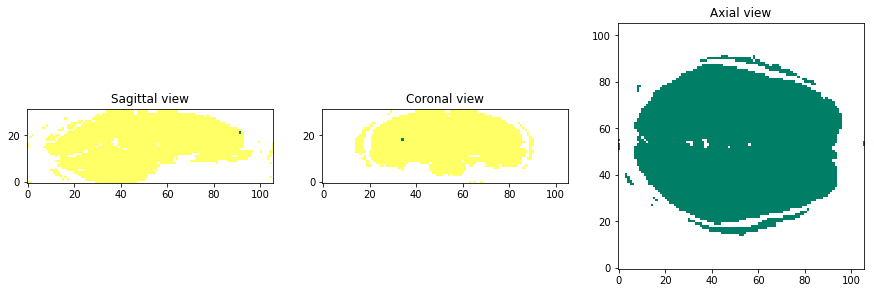

In [58]:
# Display the coefficient values for each voxel at the middle section coordinates. 
middle_coord = middle_sections(coefficients_image_lasso)
display_fMRI_image(coefficients_image_lasso[:, :, :, np.newaxis], middle_coord)

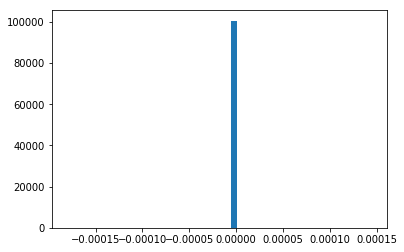

In [59]:
# Display the distribution of the coefficient values. 
plt.hist(coef_lasso, bins = 50);

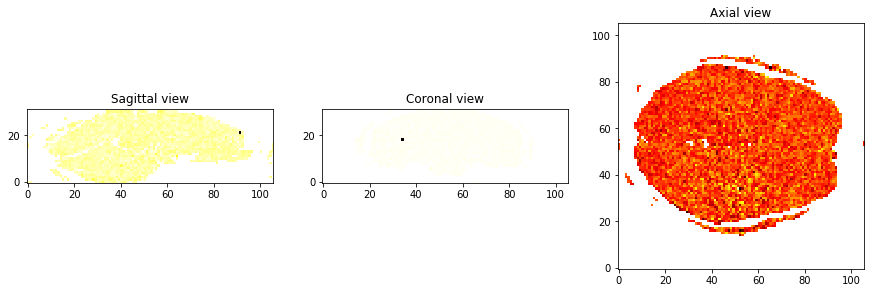

In [60]:
# Display the difference with the coefficients from the linear regression. 
display_fMRI_image(coefficients_image_lasso[:, :, :, np.newaxis] - 
                   coefficients_image_lr[:, :, :, np.newaxis], middle_coord, colormap = 'hot')

In [61]:
# Display the number non-zero coefficients, and the total number of coefficients, obtained from the Lasso regression. 
print('Non-zero coefficients: ' + str(coef_lasso[coef_lasso != 0].shape[0]))
print('Total number of coefficients: ' + str(coef_lasso.shape[0]))
print('Proportion of non-zero coefficients: ' + str(np.round(coef_lasso[coef_lasso != 0].shape[0] / coef_lasso.shape[0], 4)))

Non-zero coefficients: 83
Total number of coefficients: 100674
Proportion of non-zero coefficients: 0.0008


In [62]:
# Find the coordinates of the voxel with the highest coefficient. 
highest_coefficient_voxel = np.unravel_index(np.nanargmax(coefficients_image_lasso), coefficients_image_lasso.shape)
highest_coefficient_voxel

(32, 93, 6)

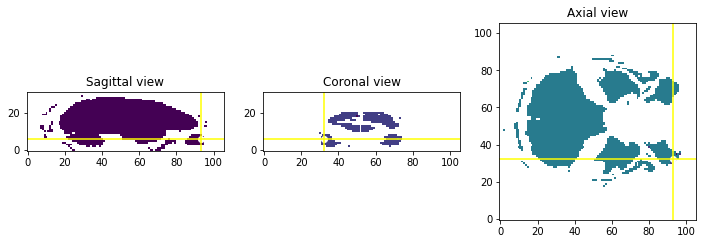

In [63]:
# Display the position of the voxel with the highest coefficient. 
display_voxel_or_cluster_position(highest_coefficient_voxel, coefficients_image_lasso, coefficients_image_lasso.shape)

**Result:** The Lasso regression performs better than the baseline. Most of the coefficients are shrunk to zero, with very few non-zero coefficients remaining. 

In [64]:
# Save the results into a .npz file. 
np.savez(results_path + 'regression_with_fMRI_predictors_single_subject_target_EEG_data.npz', 
         
         # Example subject. 
         subject_index = subject_index,
         
         # Baseline. 
         rss_baseline = rss_baseline,
         
         # Linear regression. 
         rss_lr = rss_lr, 
         r2_lr = r2_lr, 
         coef_lr = coef_lr, 
         coefficients_image_lr = coefficients_image_lr, 
         
         # Regression with Huber loss. 
         rss_huber = rss_huber, 
         r2_huber = r2_huber, 
         coef_huber = coef_huber,
         coefficients_image_huber = coefficients_image_huber, 
         
         # Ridge regression. 
         rss_ridge = rss_ridge, 
         r2_ridge = r2_ridge, 
         coef_ridge = coef_ridge, 
         coefficients_image_ridge = coefficients_image_ridge, 
         
         # Lasso regression. 
         rss_lasso = rss_lasso, 
         r2_lasso = r2_lasso, 
         coef_lasso = coef_lasso, 
         coefficients_image_lasso = coefficients_image_lasso)

### **3.2 Targets: all the EEG frequency bands**

In the following cells, we **fit and compute predictions from a linear regression** for a single subject, using successively all the EEG frequency bands as targets. 

In [65]:
# Define an example subject. 
subject_index = subjects[0]

# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [66]:
# Define the indexes of the EEG frequency bands. 
target_bands = range(5)

In [67]:
# Create a dictionary to store the results. 
lr_all_bands_results = dict()

# Iterate through all target bands. 
for target_band_index in target_bands:
    
    # Display current step. 
    print('Starting target band: ' + str(target_band_index))
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = predictors_fMRI_flatten[subject_index]
    elif rescaling_factor == 2:
        X = predictors_fMRI_flatten_r2[subject_index]
    elif rescaling_factor == 3:
        X = predictors_fMRI_flatten_r3[subject_index]
    y = predictors_EEG_200_samples[subject_index][:, target_band_index]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_bands_results[target_band_index] = {'y_te': y_te, 
                                               'y_pred_lr': y_pred_lr,
                                               'coef_lr': coef_lr,
                                               'coefficients_image_lr': coefficients_image_lr,
                                               'middle_coord': middle_coord,
                                               'rss_baseline': rss_baseline,
                                               'rss_lr': rss_lr,
                                               'r2_lr': r2_lr}

Starting target band: 0
MSE: 0.03563883402947935
MAE: 0.15901147532352997
RSS: 1.425553361179174
R^2: 0.01234892565867296

Starting target band: 1
MSE: 0.010300835842979066
MAE: 0.08227745219690652
RSS: 0.4120334337191627
R^2: 0.015219858065405933

Starting target band: 2
MSE: 0.006714891399491202
MAE: 0.06905327689016236
RSS: 0.2685956559796481
R^2: 0.46252745017719366

Starting target band: 3
MSE: 0.004694384228856504
MAE: 0.04298686914071379
RSS: 0.18777536915426016
R^2: 0.23821855048996332

Starting target band: 4
MSE: 1.1775346749469952e-05
MAE: 0.0026355301859030335
RSS: 0.0004710138699787981
R^2: -2.697082945870105



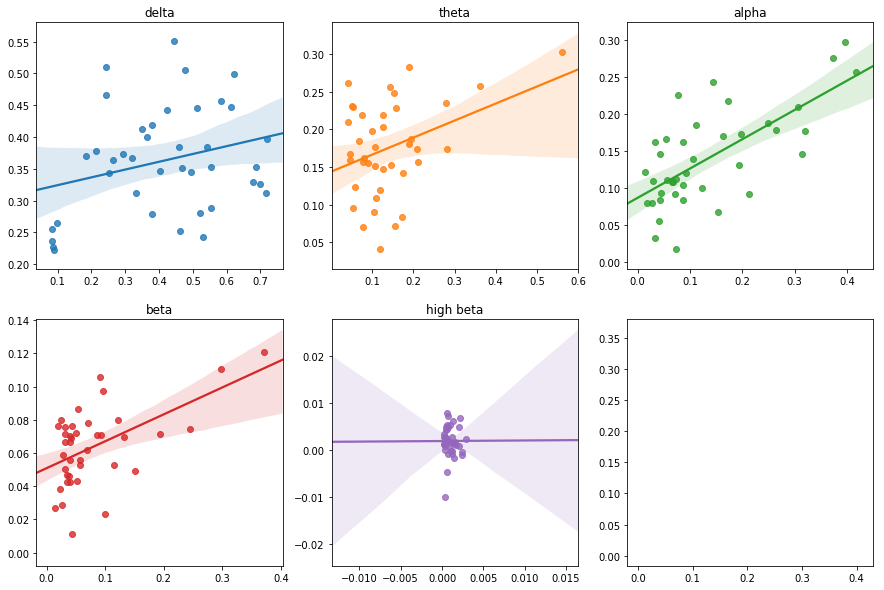

In [68]:
# Compare the true values with the predicted values, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
counter = 0
target_bands_names = ['delta', 'theta', 'alpha', 'beta', 'high beta']

# Iterate through all frequency bands. 
for target_band_index in target_bands:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graph. 
    sns.regplot(lr_all_bands_results[target_band_index]['y_te'], lr_all_bands_results[target_band_index]['y_pred_lr'], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(target_bands_names[target_band_index]);
    
    # Increment. 
    counter += 1

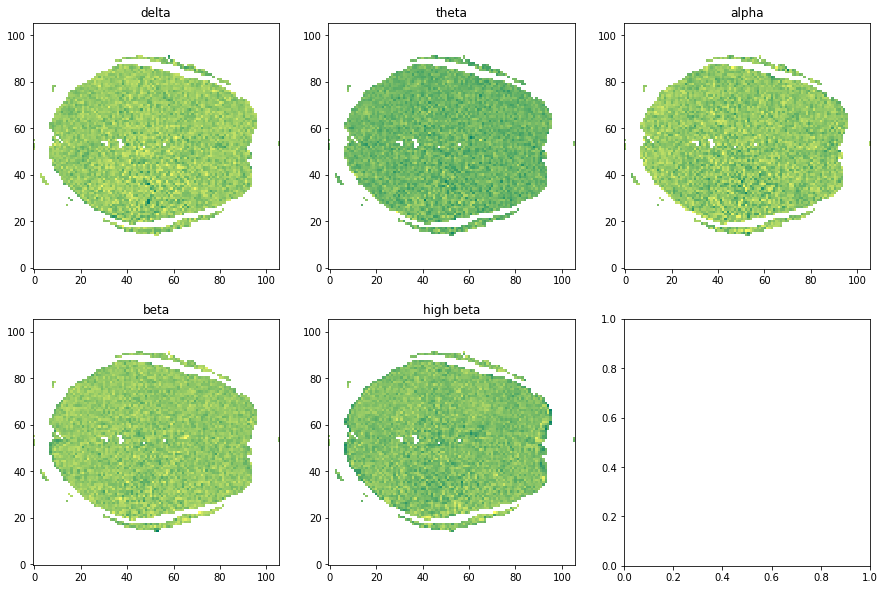

In [69]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
middle_coord = lr_all_bands_results[2]['middle_coord']
counter = 0

# Iterate through all frequency bands. 
for target_band_index in target_bands:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graph. 
    axes[row_index, column_index].imshow(lr_all_bands_results[target_band_index]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[row_index, column_index].set_title(target_bands_names[target_band_index]);
    
    # Increment. 
    counter += 1

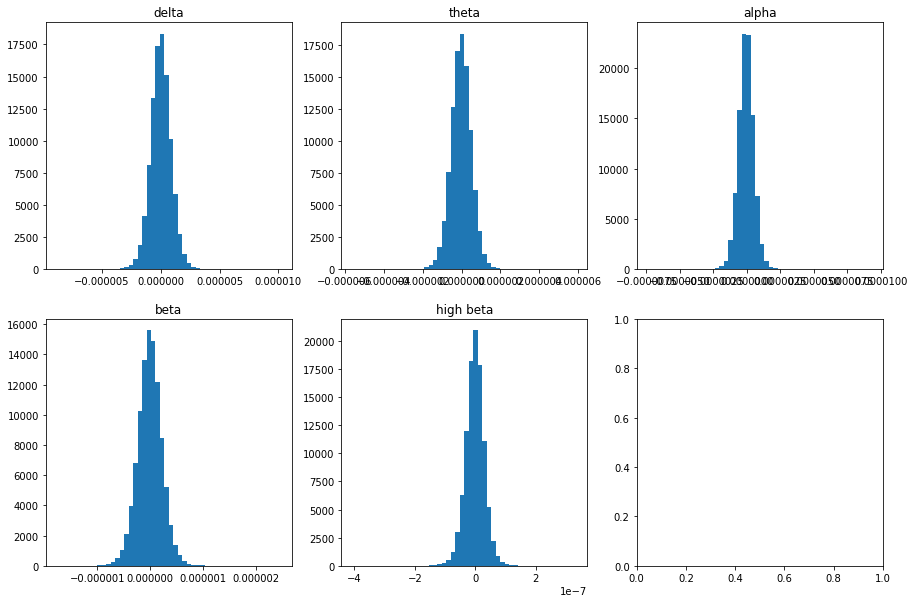

In [70]:
# Display the distribution of the coefficient values, for all EEG frequency bands. 
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 10))
counter = 0

# Iterate through all frequency bands. 
for target_band_index in target_bands:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graph. 
    axes[row_index, column_index].hist(lr_all_bands_results[target_band_index]['coef_lr'], bins = 50)
    axes[row_index, column_index].set_title(target_bands_names[target_band_index]);
    
    # Increment. 
    counter += 1

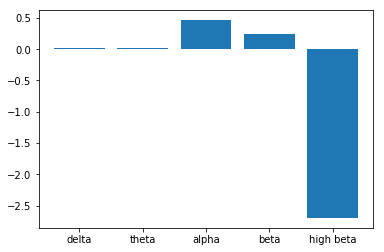

In [71]:
# Display the R^2 measure for all EEG frequency bands. 
r2_lr_all_bands = []
for target_band_index in range(5):
    r2_lr_all_bands.append(lr_all_bands_results[target_band_index]['r2_lr'])
plt.bar(range(5), r2_lr_all_bands, tick_label = target_bands_names);

**Result:** The results are variable, but typically, linear regression performs better than the baseline for most of the EEG frequency bands, except the high beta band which often behaves differently. In none of these bands do the voxels associated with the highest coefficients seem to be located in a particular brain region. 

## **4. Regression on all subjects, EEG data prediction**

### **4.1 Target: the alpha band**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the alpha band as the target. 

In [72]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 3

In [73]:
# Define the alpha band as our EEG frequency band of interest. 
target_band_index = 2

In [74]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = predictors_fMRI_flatten[subject_index]
    elif rescaling_factor == 2:
        X = predictors_fMRI_flatten_r2[subject_index]
    elif rescaling_factor == 3:
        X = predictors_fMRI_flatten_r3[subject_index]
    y = predictors_EEG_200_samples[subject_index][:, target_band_index]
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'coefficients_image_lr': coefficients_image_lr,
                                              'middle_coord': middle_coord,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}

Starting subject: sub-xp101
MSE: 0.00889042273160406
MAE: 0.07618005953829196
RSS: 0.35561690926416245
R^2: 0.3329229017723435

Starting subject: sub-xp102
MSE: 0.01536301755374852
MAE: 0.09749650665783886
RSS: 0.6145207021499408
R^2: -0.530442324452377

Starting subject: sub-xp103
MSE: 0.013784380933553164
MAE: 0.09118981268292514
RSS: 0.5513752373421266
R^2: 0.1545124696386072

Starting subject: sub-xp104
MSE: 0.004490583282950339
MAE: 0.055978637475211354
RSS: 0.17962333131801356
R^2: -0.295058275884714

Starting subject: sub-xp105
MSE: 0.012506948333600765
MAE: 0.0911427637835152
RSS: 0.5002779333440306
R^2: 0.3438550888116456

Starting subject: sub-xp106
MSE: 0.019176675477298566
MAE: 0.10652099201259597
RSS: 0.7670670190919426
R^2: 0.011189586670977913

Starting subject: sub-xp107
MSE: 0.003996619131171981
MAE: 0.051758213778510365
RSS: 0.15986476524687926
R^2: -0.013924297429269261

Starting subject: sub-xp108
MSE: 0.002444123857277608
MAE: 0.03906688559900602
RSS: 0.09776495429

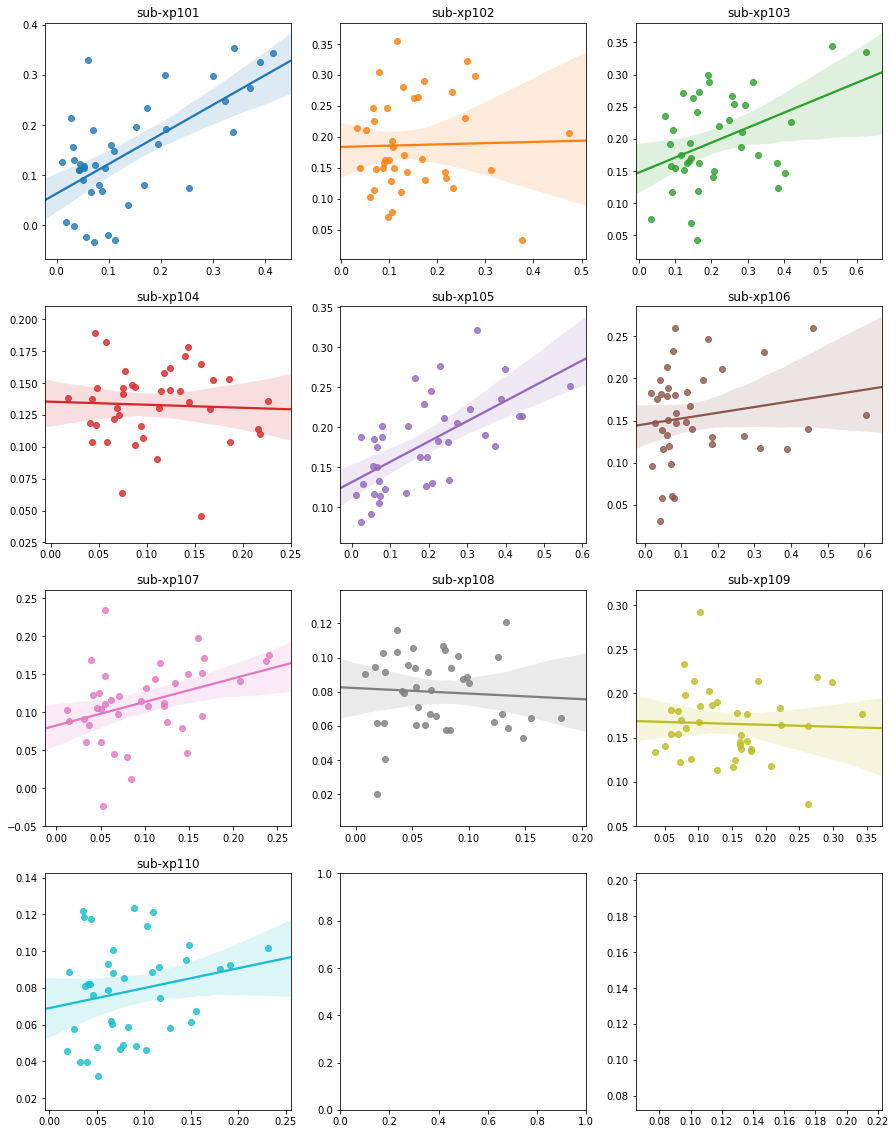

In [75]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    sns.regplot(lr_all_subjects_results[subject_index]['y_te'], lr_all_subjects_results[subject_index]['y_pred_lr'], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

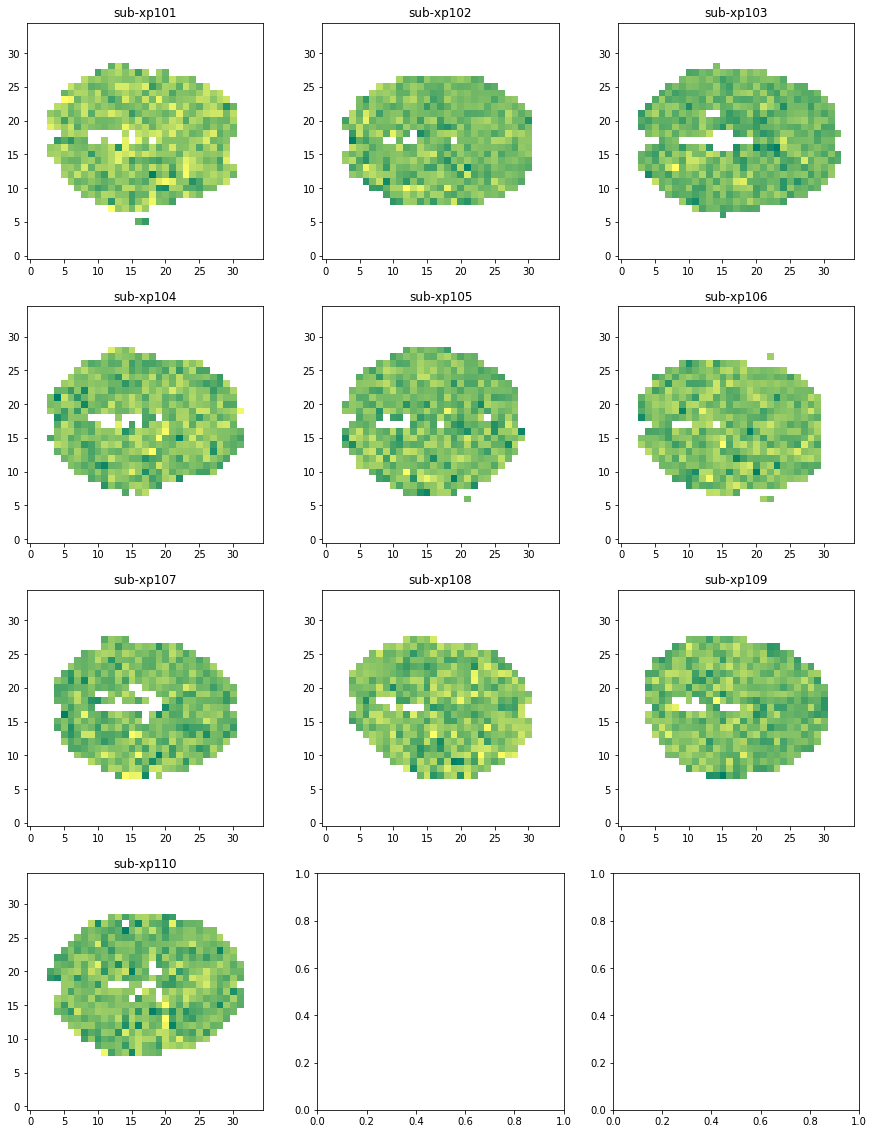

In [76]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(lr_all_subjects_results[subject_index]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[row_index, column_index].set_title(subject_index)
    
    # Increment. 
    counter += 1

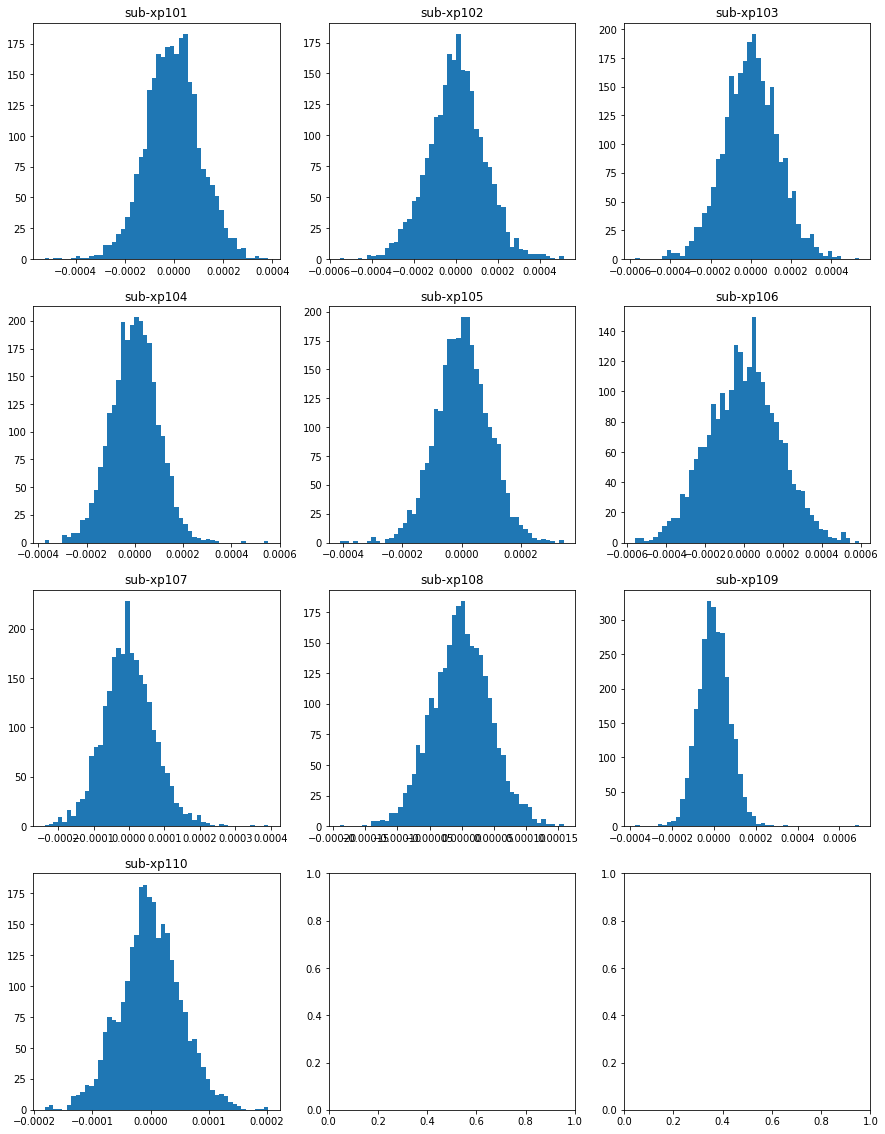

In [77]:
# Display the distribution of the coefficient values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs.     
    axes[row_index, column_index].hist(lr_all_subjects_results[subject_index]['coef_lr'], bins = 50)
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

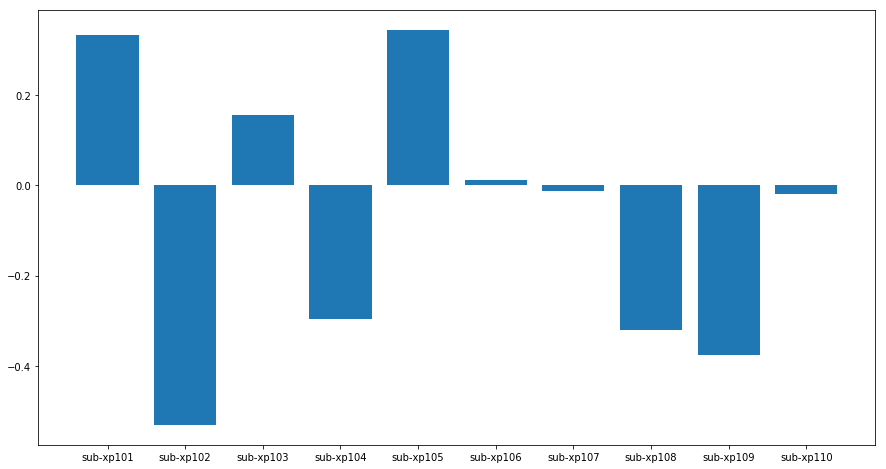

In [78]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** The results are variable, but typically, the R^2 measure shows a high predictability in some subjects, and a low or even negative predictability in others. We must remember that we are using the fMRI data with a voxel size rescaling by a factor 3, and not with the original voxel size as we did in the previous section for a single subject. 

### **4.2 Targets: all the EEG frequency bands**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects and all the EEG frequency bands. 

In [79]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 3

In [80]:
# Create a dictionary to store the results at the subject level. 
lr_results_at_subject_level = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Create a dictionary to store the results at the target band level. 
    lr_results_at_target_band_level = dict()
    
    # Iterate through all target bands. 
    for target_band_index in target_bands:
    
        # Define the features and target variables. 
        if rescaling_factor == 1:
            X = predictors_fMRI_flatten[subject_index]
        elif rescaling_factor == 2:
            X = predictors_fMRI_flatten_r2[subject_index]
        elif rescaling_factor == 3:
            X = predictors_fMRI_flatten_r3[subject_index]
        y = predictors_EEG_200_samples[subject_index][:, target_band_index]

        # Divide the data into a train set and a test set. 
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)

        # Baseline model: mean value of the alpha band in the train set. 
        rss_baseline = RSS(y_te, np.mean(y_tr))

        # Run a linear regression. 
        y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
            LinearRegression(), X_tr, X_te, y_tr, y_te, display_results = False, return_rank = True)

        # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
        if rescaling_factor == 1:
            non_nan_indexes = non_nan_indexes_fMRI[subject_index]
        elif rescaling_factor == 2:
            non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
        elif rescaling_factor == 3:
            non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
        coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
        middle_coord = middle_sections(coefficients_image_lr)

        # Store the results in the dictionary. 
        lr_results_at_target_band_level[target_band_index] = {'y_te': y_te, 
                                                              'y_pred_lr': y_pred_lr,
                                                              'coef_lr': coef_lr,
                                                              'coefficients_image_lr': coefficients_image_lr,
                                                              'middle_coord': middle_coord,
                                                              'rss_baseline': rss_baseline,
                                                              'rss_lr': rss_lr,
                                                              'r2_lr': r2_lr}
    # Store the results in the dictionary. 
    lr_results_at_subject_level[subject_index] = lr_results_at_target_band_level

Starting subject: sub-xp101
Starting subject: sub-xp102
Starting subject: sub-xp103
Starting subject: sub-xp104
Starting subject: sub-xp105
Starting subject: sub-xp106
Starting subject: sub-xp107
Starting subject: sub-xp108
Starting subject: sub-xp109
Starting subject: sub-xp110


In [81]:
# Define a function to display the R^2 value for all subjects, for a certain target band. 
def plot_r2_for_all_subjects(target_band_index):
    color_names = ['blue', 'green', 'gold', 'orange', 'red']
    r2_lr_all_subjects = []
    for subject_index in subjects:
        r2_lr_all_subjects.append(lr_results_at_subject_level[subject_index][target_band_index]['r2_lr'])
    plt.figure(figsize = (15, 8))
    plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects, color = color_names[target_band_index])
    plt.title(target_bands_names[target_band_index]);

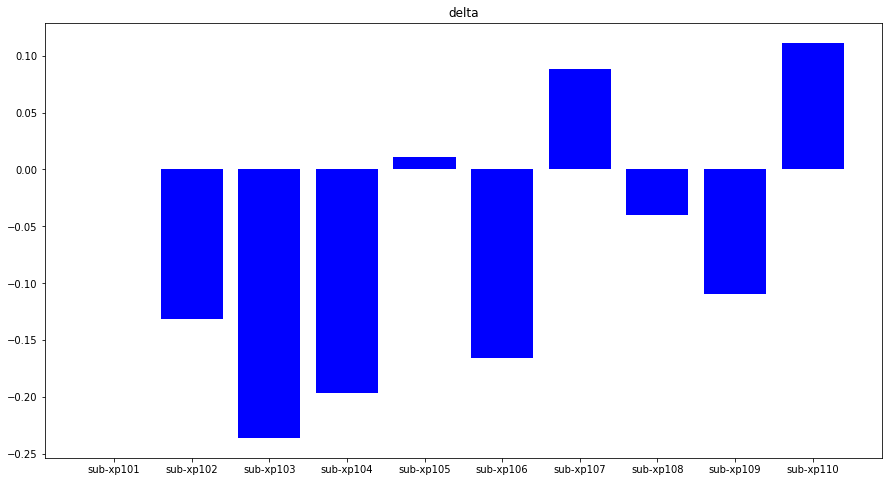

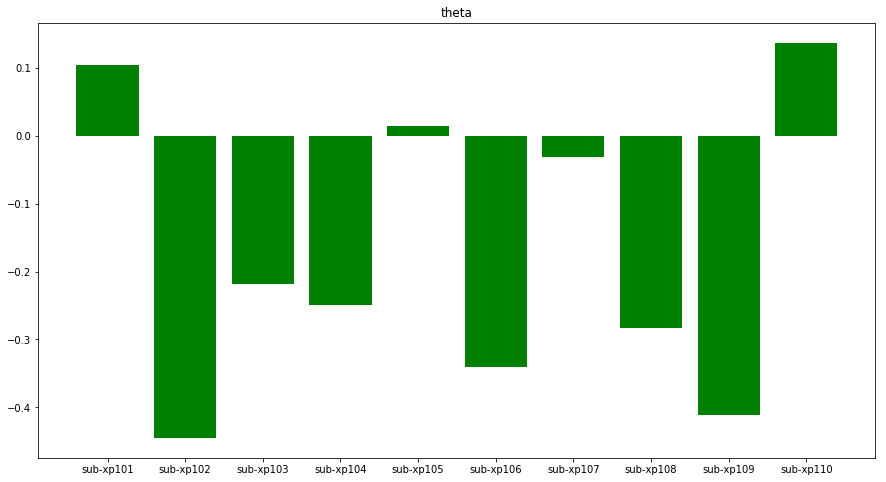

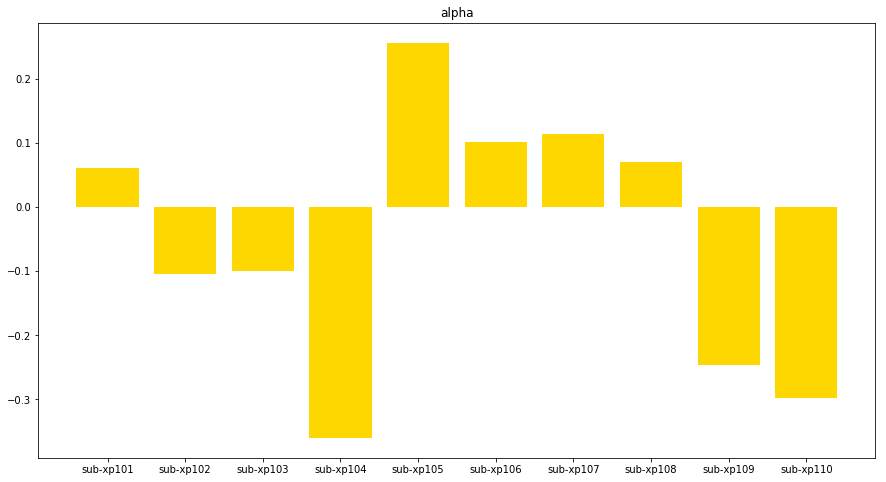

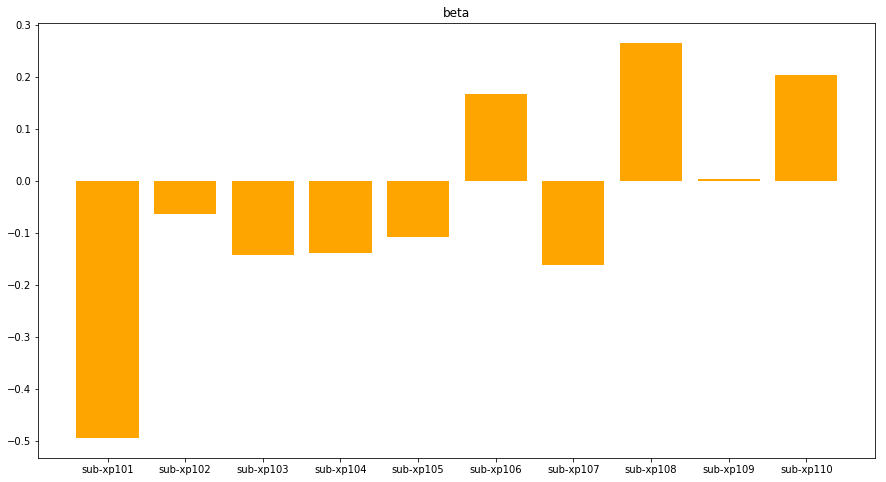

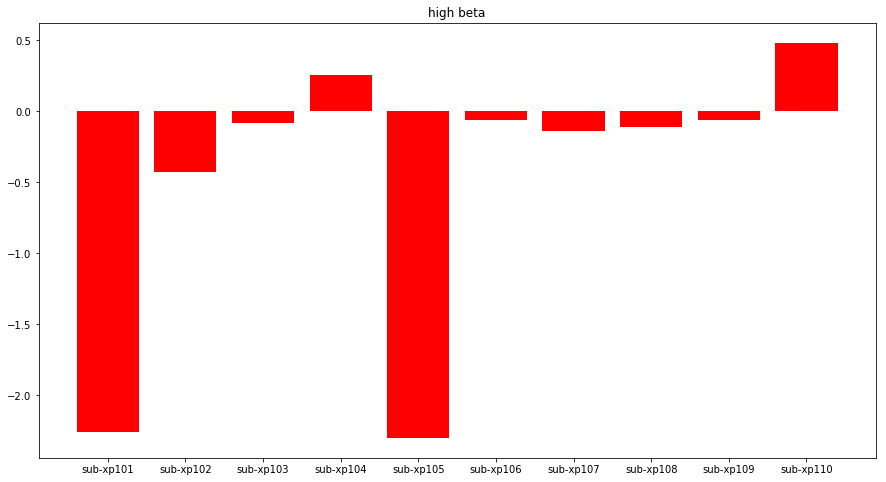

In [82]:
# Display the R^2 value for all subjects and all EEG frequency bands. 
for target_band_index in range(5):
    plot_r2_for_all_subjects(target_band_index)

**Result:** The results are variable, but typically, the linear regression shows significant differences across subjects and frequency bands. The R^2 measure shows a good predictability in some cases, and a low or negative predictability in others. Again, we must remember that we are using the fMRI data with a voxel size rescaling by a factor 3, and not with the original voxel size as we did in the previous section for a single subject. 

In [83]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_EEG_data.p', 'wb') as file:
    pickle.dump(lr_results_at_subject_level, file)

## **5. Regression on all subjects, NF scores prediction**

### **5.1 Target: fMRI NF scores**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the fMRI NF scores as the target. 

In [84]:
import h5py

In [85]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [86]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the path of the .mat file for this subject, for the eegfmriNF condition. 
    mat_path = data_path + 'derivatives/' + subject_index + '/NF_bold/d_' + subject_index + '_task-eegfmriNF_NFbold_scores.mat'
    
    # Load the .mat file, extract the data et store the NF scores. 
    f = h5py.File(mat_path, 'r')
    mat_data = f.get('NF_bold')
    fmri_nf_scores = np.array(mat_data['nf_laterality'])
    fmri_nf_scores = fmri_nf_scores[:, 0]
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = predictors_fMRI_flatten[subject_index]
    elif rescaling_factor == 2:
        X = predictors_fMRI_flatten_r2[subject_index]
    elif rescaling_factor == 3:
        X = predictors_fMRI_flatten_r3[subject_index]
    y = fmri_nf_scores
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'coefficients_image_lr': coefficients_image_lr,
                                              'middle_coord': middle_coord,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}

Starting subject: sub-xp101
MSE: 0.7058027205739925
MAE: 0.5627032368615656
RSS: 28.232108822959702
R^2: -0.1976462194104509

Starting subject: sub-xp102
MSE: 0.23415269845403927
MAE: 0.38749147453131194
RSS: 9.366107938161571
R^2: 0.3175087398809292

Starting subject: sub-xp103
MSE: 0.1447422010888339
MAE: 0.31361339721976644
RSS: 5.789688043553356
R^2: 0.22309972445867743

Starting subject: sub-xp104
MSE: 0.09869290826934066
MAE: 0.24036716120952875
RSS: 3.947716330773626
R^2: 0.3264714170144797

Starting subject: sub-xp105
MSE: 0.634072436193301
MAE: 0.5627877577635785
RSS: 25.36289744773204
R^2: -0.09859551317757642

Starting subject: sub-xp106
MSE: 0.12534247563760886
MAE: 0.29140983390541964
RSS: 5.013699025504355
R^2: 0.3594724303229897

Starting subject: sub-xp107
MSE: 0.6840736797874281
MAE: 0.641699141840077
RSS: 27.36294719149712
R^2: 0.29268348098769115

Starting subject: sub-xp108
MSE: 0.10690924519620208
MAE: 0.25517541808896504
RSS: 4.276369807848083
R^2: 0.2959005856502

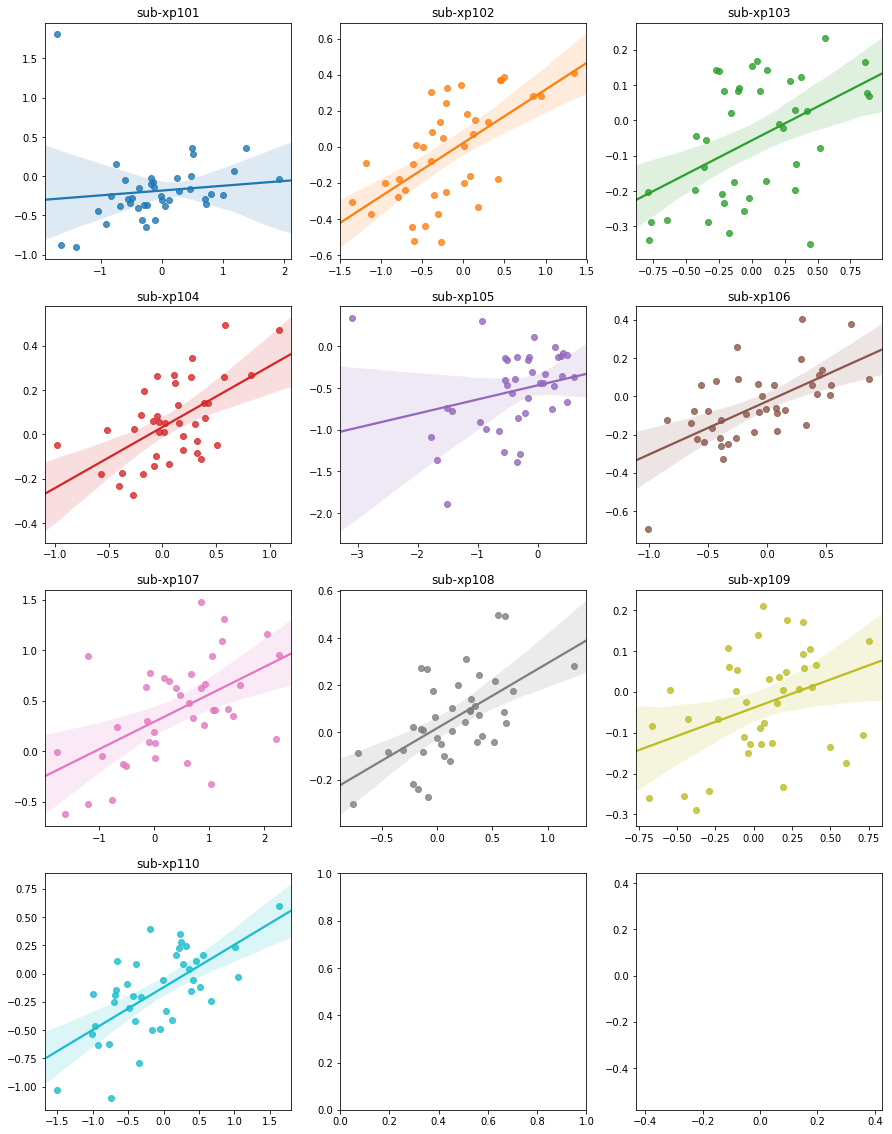

In [87]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    sns.regplot(lr_all_subjects_results[subject_index]['y_te'], lr_all_subjects_results[subject_index]['y_pred_lr'], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

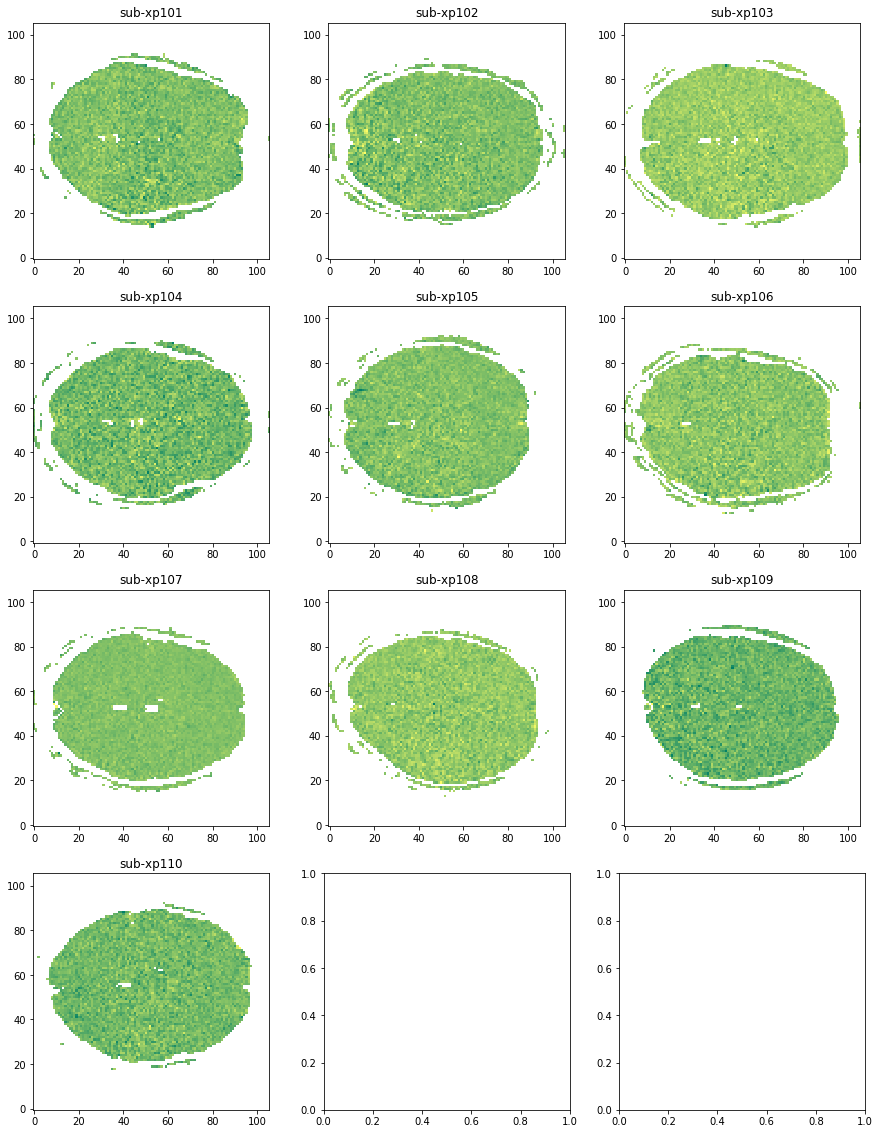

In [88]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(lr_all_subjects_results[subject_index]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[row_index, column_index].set_title(subject_index)
    
    # Increment. 
    counter += 1

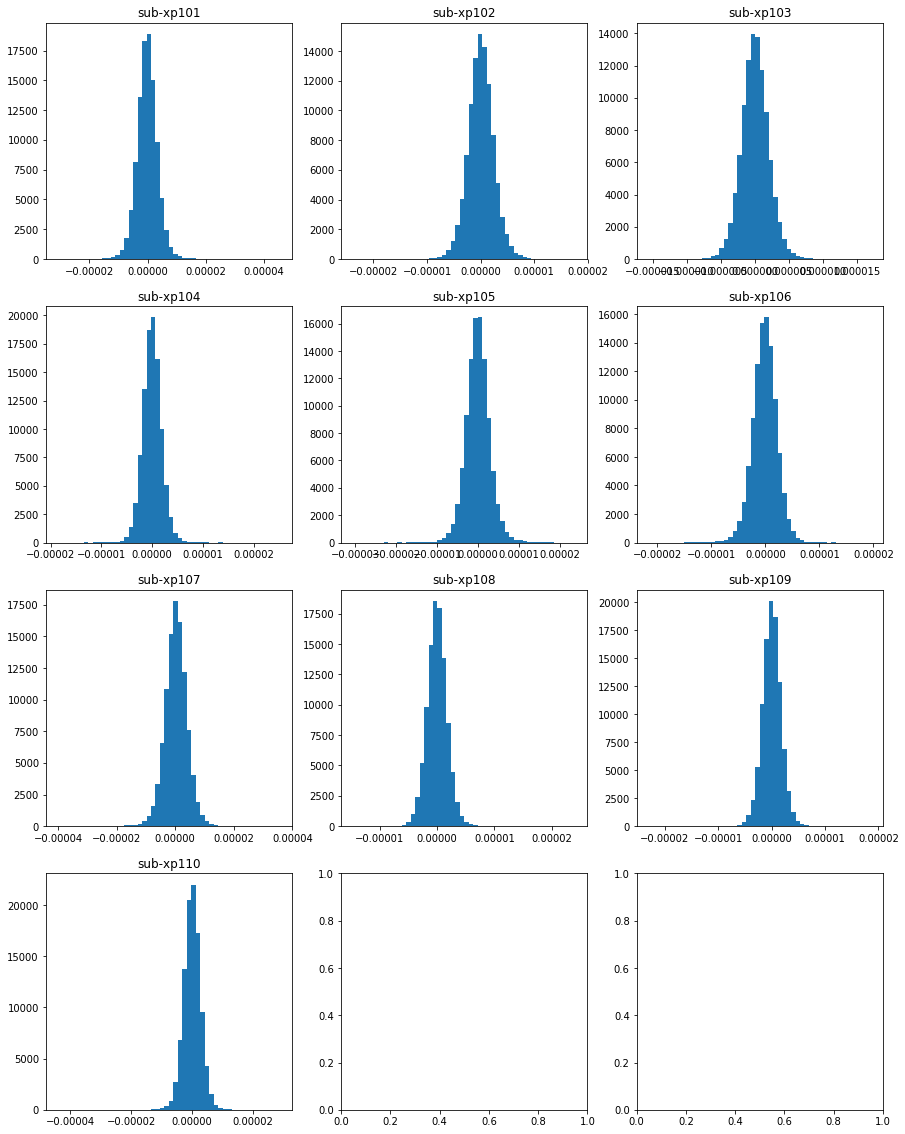

In [89]:
# Display the distribution of the coefficient values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs.     
    axes[row_index, column_index].hist(lr_all_subjects_results[subject_index]['coef_lr'], bins = 50)
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

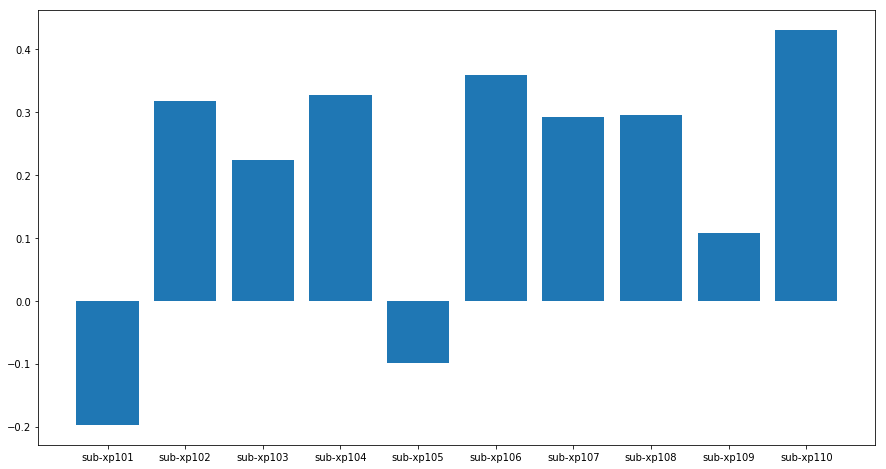

In [90]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** The results are variable, but typically, linear regression performs better than the baseline for most of the subjects. Overall, the R^2 measure shows a good predictability, which was expected since the fMRI NF scores were computed using the fMRI data in the first place. 

In [91]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_fMRI_NF_scores.p', 'wb') as file:
    pickle.dump(lr_all_subjects_results, file)

### **5.2 Target: EEG NF scores**

In the following cells, we **fit and compute predictions from a linear regression** for all the subjects, using the EEG NF scores as the target. Since the EEG NF scores were computed with 1600 data points for the eegfmriNF run, we must resample these scores to 200 data points, in order to use the fMRI data as predictors. 

In [92]:
# Define the voxel size rescaling factor to be used. 1: original voxel size. 2: factor 2. 3: factor 3. 
rescaling_factor = 1

In [93]:
# Create a dictionary to store the results. 
lr_all_subjects_results = dict()

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Display current step. 
    print('Starting subject: ' + subject_index)
    
    # Define the path of the .mat file for this subject, for the eegfmriNF condition. 
    mat_path = data_path + 'derivatives/' + subject_index + '/NF_eeg/d_' + subject_index + '_task-eegfmriNF_NFeeg_scores.mat'
    
    # Load the .mat file, extract the data et store the NF scores. 
    f = h5py.File(mat_path, 'r')
    mat_data = f.get('NF_eeg')
    eeg_nf_scores_1600_samples = np.array(mat_data['nf_laterality'])
    eeg_nf_scores_1600_samples = np.nan_to_num(eeg_nf_scores_1600_samples[:, 0])
    
    # Resample the EEG NF scores. 
    eeg_nf_scores_200_samples = np.zeros(200)
    for nf_score_index in range(200):
        eeg_nf_scores_200_samples[nf_score_index] = np.mean(eeg_nf_scores_1600_samples[(nf_score_index * 4):((nf_score_index * 4) + 4)])
    
    # Define the features and target variables. 
    if rescaling_factor == 1:
        X = predictors_fMRI_flatten[subject_index]
    elif rescaling_factor == 2:
        X = predictors_fMRI_flatten_r2[subject_index]
    elif rescaling_factor == 3:
        X = predictors_fMRI_flatten_r3[subject_index]
    y = eeg_nf_scores_200_samples
    
    # Divide the data into a train set and a test set. 
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = test_set_proportion)
    
    # Baseline model: mean value of the alpha band in the train set. 
    rss_baseline = RSS(y_te, np.mean(y_tr))
    
    # Run a linear regression. 
    y_pred_lr, mse_lr, mae_lr, rss_lr, r2_lr, coef_lr, rank_lr = regression_model(
        LinearRegression(), X_tr, X_te, y_tr, y_te, return_rank = True)
    print()
    
    # Create a NumPy array, mapping the coefficients from the regression model to the 3D brain image. 
    if rescaling_factor == 1:
        non_nan_indexes = non_nan_indexes_fMRI[subject_index]
    elif rescaling_factor == 2:
        non_nan_indexes = non_nan_indexes_fMRI_r2[subject_index]
    elif rescaling_factor == 3:
        non_nan_indexes = non_nan_indexes_fMRI_r3[subject_index]
    coefficients_image_lr = create_coefficients_image(non_nan_indexes, coef_lr)
    middle_coord = middle_sections(coefficients_image_lr)
    
    # Store the results in the dictionary. 
    lr_all_subjects_results[subject_index] = {'y_te': y_te, 
                                              'y_pred_lr': y_pred_lr,
                                              'coef_lr': coef_lr,
                                              'coefficients_image_lr': coefficients_image_lr,
                                              'middle_coord': middle_coord,
                                              'rss_baseline': rss_baseline,
                                              'rss_lr': rss_lr,
                                              'r2_lr': r2_lr}

Starting subject: sub-xp101
MSE: 0.01715658676217027
MAE: 0.09960612999026539
RSS: 0.6862634704868108
R^2: 0.13326372288505917

Starting subject: sub-xp102
MSE: 0.07176066309266607
MAE: 0.2240703972824643
RSS: 2.8704265237066426
R^2: 0.024494301327731227

Starting subject: sub-xp103
MSE: 0.06409733900482276
MAE: 0.22023216726074687
RSS: 2.5638935601929105
R^2: 0.17103413724864647

Starting subject: sub-xp104
MSE: 0.0650571210370628
MAE: 0.20700775501113258
RSS: 2.602284841482512
R^2: 0.029776193544832186

Starting subject: sub-xp105
MSE: 0.09065131269473672
MAE: 0.232213644335185
RSS: 3.626052507789469
R^2: -0.08835145398666633

Starting subject: sub-xp106
MSE: 0.09912675155850031
MAE: 0.2545340203009254
RSS: 3.9650700623400126
R^2: 0.09696001383761843

Starting subject: sub-xp107
MSE: 0.03263881186060347
MAE: 0.14068010305119089
RSS: 1.3055524744241387
R^2: 0.025437708197092346

Starting subject: sub-xp108
MSE: 0.05726920458510924
MAE: 0.18279864099472837
RSS: 2.29076818340437
R^2: -0

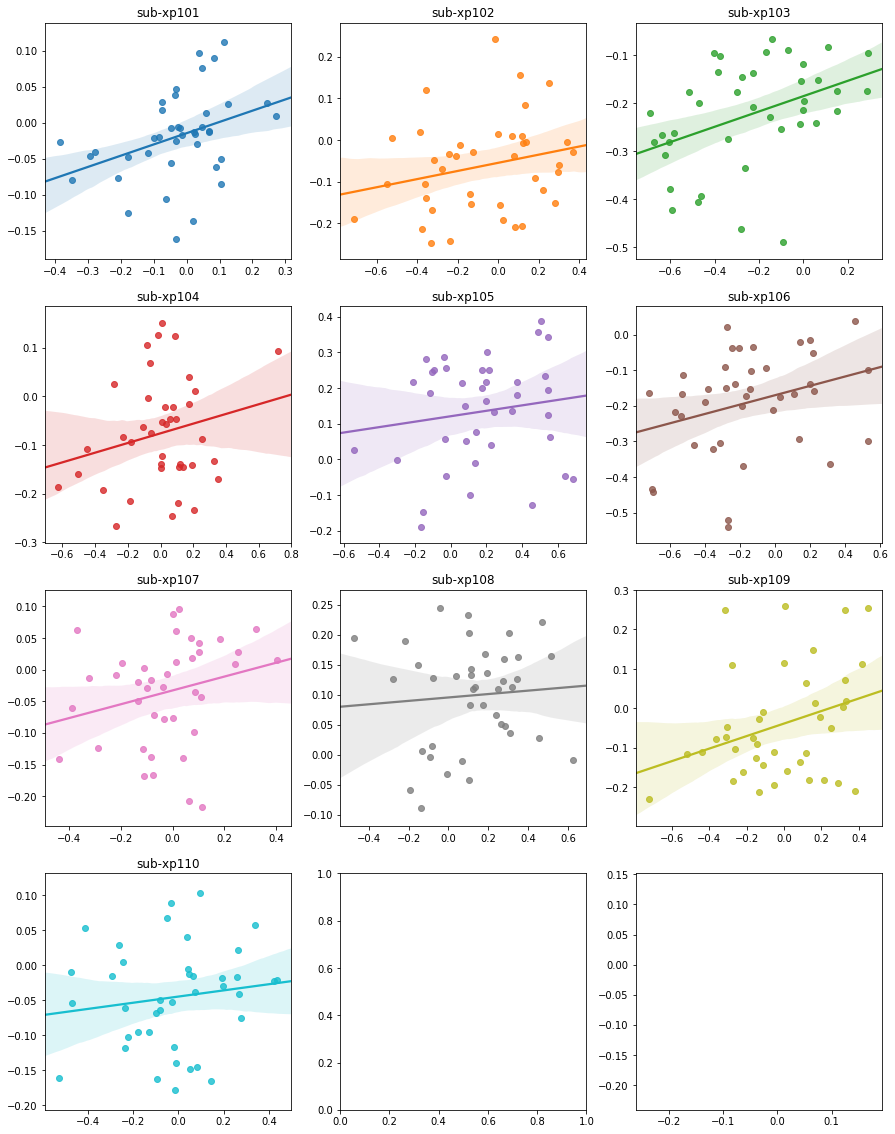

In [94]:
# Compare the true values with the predicted values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    sns.regplot(lr_all_subjects_results[subject_index]['y_te'], lr_all_subjects_results[subject_index]['y_pred_lr'], ax = axes[row_index, column_index])
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

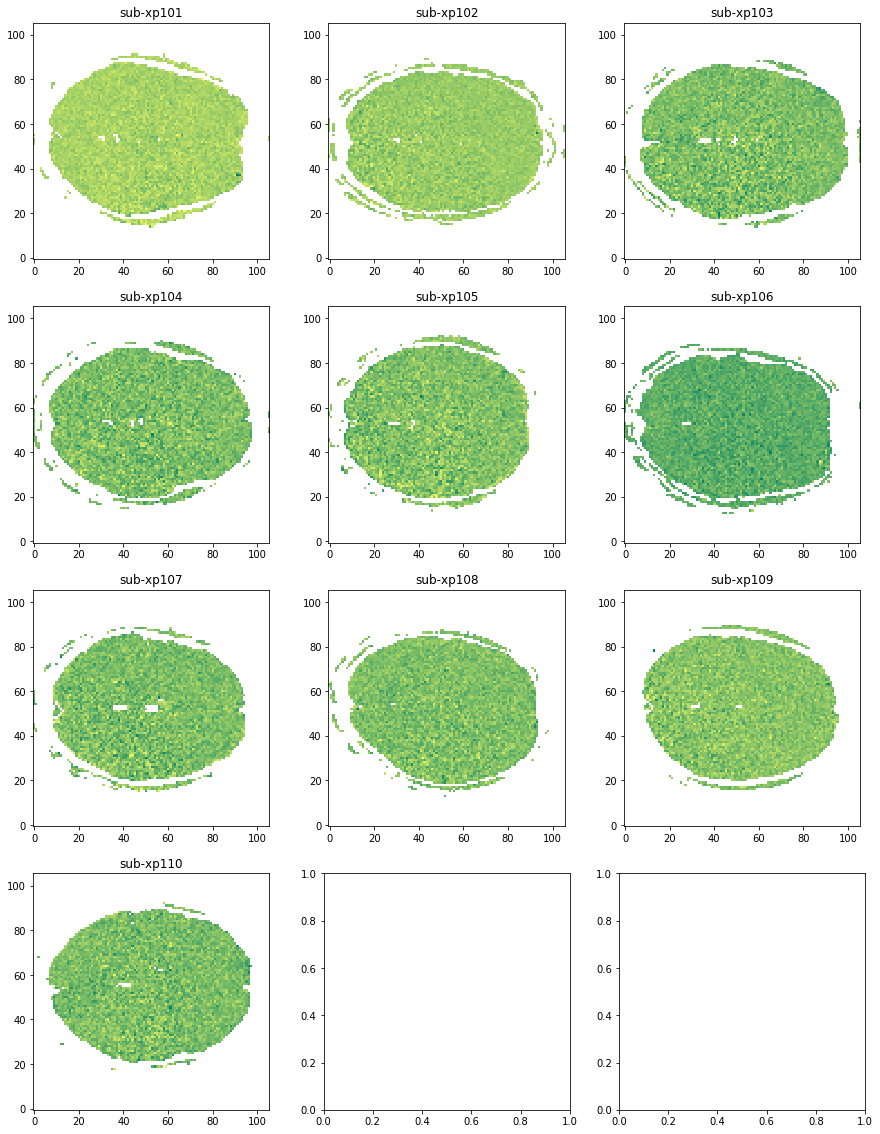

In [95]:
# Display the coefficient values for each voxel at the middle section of the axial view, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs. 
    middle_coord = lr_all_subjects_results[subject_index]['middle_coord']
    axes[row_index, column_index].imshow(lr_all_subjects_results[subject_index]['coefficients_image_lr'][:, :, middle_coord[2]], origin = 'lower', cmap = 'summer')
    axes[row_index, column_index].set_title(subject_index)
    
    # Increment. 
    counter += 1

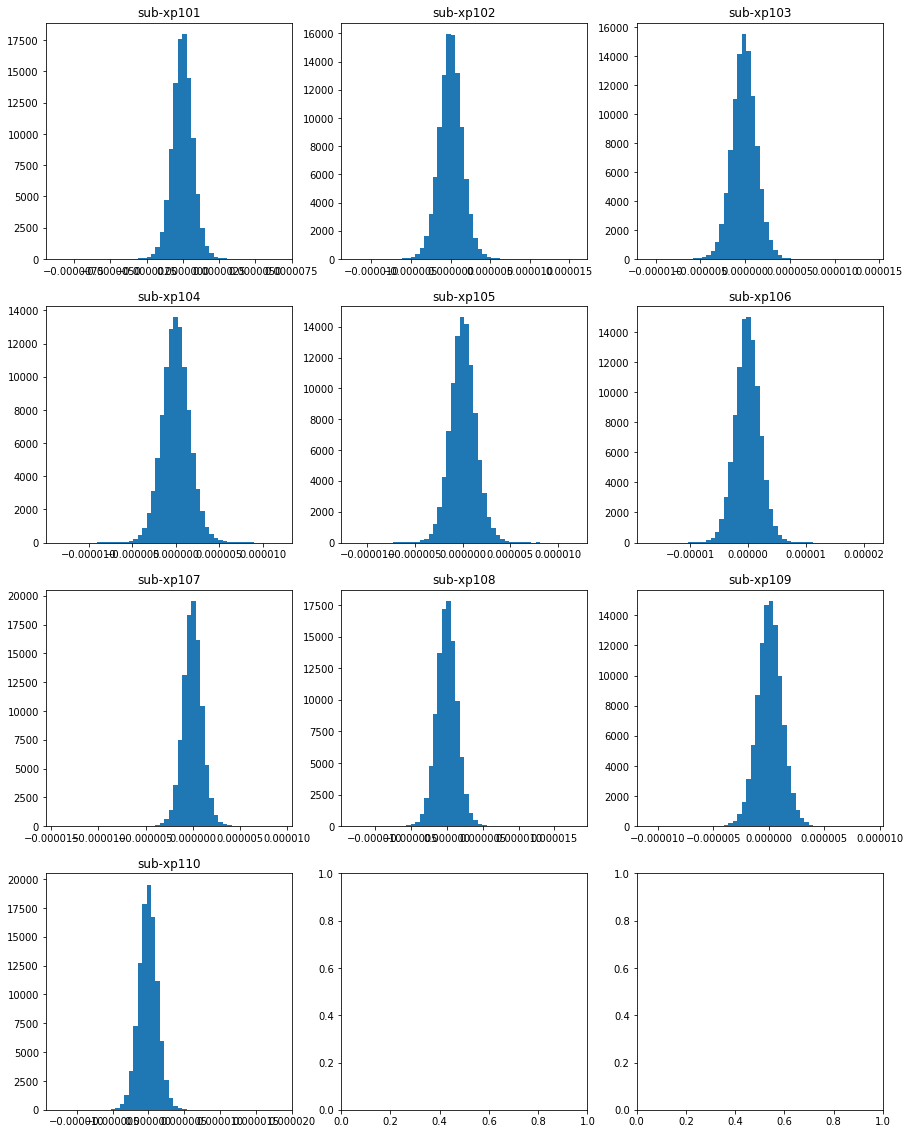

In [96]:
# Display the distribution of the coefficient values, for all subjects. 
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (15, 20))
counter = 0

# Iterate through all subjects. 
for subject_index in subjects:
    
    # Compute the row and column indexes. 
    row_index = counter // 3
    column_index = counter % 3
    
    # Draw the graphs.     
    axes[row_index, column_index].hist(lr_all_subjects_results[subject_index]['coef_lr'], bins = 50)
    axes[row_index, column_index].set_title(subject_index);
    
    # Increment. 
    counter += 1

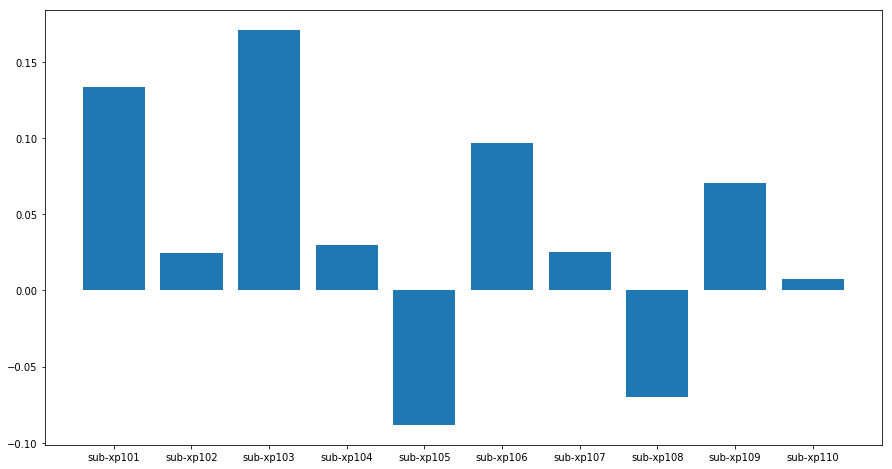

In [97]:
# Display the R^2 measure for all subjects. 
r2_lr_all_subjects = []
for subject_index in subjects:
    r2_lr_all_subjects.append(lr_all_subjects_results[subject_index]['r2_lr'])
plt.figure(figsize = (15, 8))
plt.bar(range(10), r2_lr_all_subjects, tick_label = subjects);

**Result:** The results are variable, but typically, linear regression performs better than the baseline for most of the subjects. Overall, the R^2 measure shows a relatively good predictability. 

In [98]:
# Save the results into a Pickle file. 
with open(results_path + 'regression_with_fMRI_predictors_all_subjects_target_EEG_NF_scores.p', 'wb') as file:
    pickle.dump(lr_all_subjects_results, file)